In [1]:
from catboost import CatBoostClassifier, Pool, metrics
import numpy as np
import pandas as pd
from pandas.api.indexers import FixedForwardWindowIndexer
import shap
from sklearn.base import BaseEstimator, TransformerMixin
import ta
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

In [2]:
from backtesting import Backtest
from backtesting import Strategy

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.


Loading BokehJS ...

In [239]:
DATA_DIR = "data"

In [416]:
df = pd.read_csv(os.path.join(DATA_DIR, "btcusd.csv"))
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [417]:
df.time = pd.to_datetime(df.time, unit="ms")
df = df.set_index("time")

In [418]:
freq = "5Min"
df = df.resample(freq).last().dropna()

In [419]:
df.dtypes

Open      float64
Close     float64
High      float64
Low       float64
Volume    float64
dtype: object

In [420]:
df = df[df.index.year > 2016]

In [475]:
class SmoothingWindowLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, *, window_size=100, alpha=0.04):
        self.window_size = window_size
        self.alpha = alpha
        self.indexer = FixedForwardWindowIndexer(window_size=self.window_size)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        forward_mean = X.Close.rolling(self.indexer, min_periods=1).mean()
        backward_mean = X.Close.rolling(window=self.window_size).mean()
        X["label"] = (forward_mean - backward_mean) / backward_mean
        less = np.where(X.label < -self.alpha)[0]
        greater = np.where(X.label > self.alpha)[0]
        between = np.setdiff1d(np.arange(X.label.size), np.concatenate((less, greater)))
        mapped_label = X.label.copy()
        mapped_label.iloc[less] = -1
        mapped_label.iloc[greater] = 1
        mapped_label.iloc[between] = 0
        X.label = mapped_label
        return X
    
    def fit_transform(self, X, y=None):
        X = self.transform(X)
        return X

In [476]:
labeler = SmoothingWindowLabeler()

In [477]:
df = labeler.fit_transform(df)

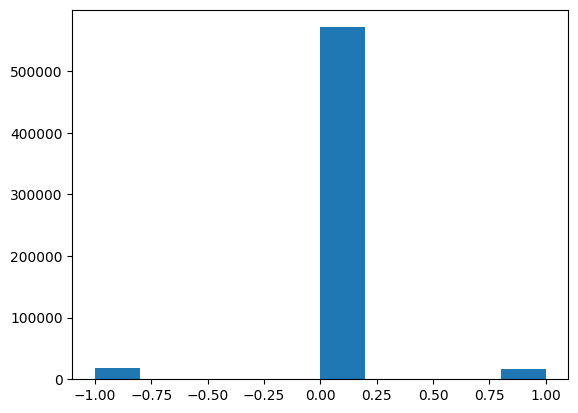

In [478]:
plt.hist(df.label)
plt.show()

In [479]:
df_small = df[-10_000:]
labels = df_small.label.to_numpy()

buy_indices = np.where(labels == 1)[0]
sell_indices = np.where(labels == -1)[0]

fig = px.line(x=range(len(df_small)), y=df_small.Close)

fig.add_trace(
    go.Scatter(
        x=buy_indices,
        y=df_small.iloc[buy_indices].Close,
        mode="markers",
        line=go.scatter.Line(color="green"),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        x=sell_indices,
        y=df_small.iloc[sell_indices].Close,
        mode="markers",
        line=go.scatter.Line(color="red"),
        showlegend=False
    )
)

fig.show()

In [480]:
#df_all = ta.add_all_ta_features(df[-1_000_000:].copy(), open="open", high="high", low="low", close="close", volume="volume")

In [481]:
df["rsi"] = ta.momentum.rsi(df.Close)

In [482]:
df.dropna()

,Open,Close,High,Low,Volume,label,rsi
time,,,,,,,
2017-01-01 01:10:00,967.200000,967.200000,967.200000,967.200000,0.997800,0.0,55.020163
2017-01-01 01:15:00,967.210000,967.210000,967.210000,967.210000,0.100000,0.0,55.147823
2017-01-01 01:20:00,967.210000,967.000000,967.210000,967.000000,2.400000,0.0,51.821583
2017-01-01 01:25:00,967.000000,967.000000,967.000000,967.000000,0.500000,0.0,51.821583
2017-01-01 01:30:00,966.110000,966.000000,966.110000,966.000000,10.775671,0.0,38.872975
...,...,...,...,...,...,...,...
2022-10-11 09:05:00,19106.000000,19105.000000,19111.000000,19104.022452,24.826783,0.0,53.526841
2022-10-11 09:10:00,19105.000000,19103.000000,19105.000000,19100.384286,4.063076,0.0,52.562087
2022-10-11 09:15:00,19090.000000,19085.000000,19090.000000,19085.000000,0.000179,0.0,44.745433


In [483]:
train_df = df[(df.index.year > 2019) & (df.index.year < 2021)]
val_df = df[(df.index.year > 2020) & (df.index.year < 2022)]
test_df = df[df.index.year > 2021]

print(f"train len: {len(train_df)}")
print(f"val len: {len(val_df)}")
print(f"test len: {len(test_df)}")

train len: 105267
val len: 104872
test len: 81604


In [484]:
features = ['rsi']

X_train, y_train = train_df[train_df.columns[train_df.columns.isin(features)]], train_df.label
X_val, y_val = val_df[val_df.columns[val_df.columns.isin(features)]], val_df.label
X_test, y_test = test_df[test_df.columns[test_df.columns.isin(features)]], test_df.label

In [485]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

In [486]:
classifier = CatBoostClassifier(
    iterations=100,
    auto_class_weights='Balanced'
)
classifier.fit(
    train_pool,
    eval_set=[val_pool, test_pool],
    use_best_model=True,
    verbose=200,
    plot_file=f'loss_plot.html'
)

Learning rate set to 0.28561
0:	learn: 0.9655699	test: 0.9572869	test1: 0.9476302	best: 0.9476302 (0)	total: 14.7ms	remaining: 1.45s
99:	learn: 0.7642205	test: 0.8003563	test1: 0.7641603	best: 0.7516689 (14)	total: 1.45s	remaining: 0us

bestTest = 0.7516689383
bestIteration = 14

Shrink model to first 15 iterations.


In [487]:
preds = None

def predict_values(model, df):
    predictions = model.predict(df)
    global preds
    return predictions.flatten()

class CatboostClassifier(Strategy):
    def init(self):
        global classifier
        global features
        self.model = classifier
        # precompute all predictions
        self.predictions = self.I(predict_values, self.model, self.data.df[features])
        taste = self.predictions
    
    def next(self):
        prediction = self.predictions[-1]
        curr_pred = prediction
        
        if prediction == 1:
            if not self.position.is_long:
                #self.position.close()
                self.buy(size=0.999)
        elif prediction == -1:
            if not self.position.is_short:
                #self.position.close()
                self.sell(size=0.999)

In [488]:
bt = Backtest(test_df, CatboostClassifier, cash=1_000_000, commission=.000, exclusive_orders=True)

In [489]:
stats = bt.run()

In [490]:
stats

Start                     2022-01-01 00:00:00
End                       2022-10-11 09:25:00
Duration                    283 days 09:25:00
Exposure Time [%]                   99.990197
Equity Final [$]                777166.328415
Equity Peak [$]                1174613.018039
Return [%]                         -22.283367
Buy & Hold Return [%]              -58.770055
Return (Ann.) [%]                  -21.655869
Volatility (Ann.) [%]                53.45337
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -40.042949
Avg. Drawdown [%]                   -4.432314
Max. Drawdown Duration      214 days 19:55:00
Avg. Drawdown Duration       10 days 11:50:00
# Trades                                 2445
Win Rate [%]                        29.120654
Best Trade [%]                      10.605046
Worst Trade [%]                     -6.662125
Avg. Trade [%]                    

In [491]:
print(f"Test Accuracy: {classifier.eval_metrics(test_pool, ['Accuracy'])['Accuracy'][-1]}")
#print(f"Test AUC: {classifier.eval_metrics(test_pool, ['AUC'])['AUC'][-1]}")


Test Accuracy: 0.6315292921523591


In [492]:
pd.Series(y_test).value_counts()

 0.0    78164
-1.0     2059
 1.0     1381
Name: label, dtype: int64